In [13]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.grid_search import GridSearchCV
%matplotlib inline

Load the dataset and separate the labels from the features

In [14]:
data = pd.read_csv('data/Data2.csv')
target = data['Target']
features = data.drop('Target', axis = 1)

## Data exploration

In [15]:
data.head()

,Target,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A15,A16,A17,A18,A19,A20,A21,A24,A23,A22
0,1,18,1049,21,1,1,1,4,2,1,...,4,3,1,3,1,1,A,C,A,B
1,1,9,2799,36,2,2,1,4,0,1,...,2,3,1,3,1,1,C,D,C,D
2,1,12,841,23,1,1,2,2,9,2,...,4,3,1,2,1,1,C,D,C,B
3,1,12,2122,39,2,2,1,4,0,1,...,2,3,1,2,1,2,C,C,D,C
4,1,12,2171,38,2,1,1,4,0,1,...,4,1,2,2,1,2,B,D,D,D


Our dataset is composed 1 numerical target and 22 features:

- A21 to A24 features are of string categorical type. They will be encoded before training
- A4 to A20 features are of integer type, probably categorical too, not sure.
- A1 to A3 are numerical values and seem to be of different scales.

### simple data quality check (missing values)

In [16]:
print ('The dataset has {0} data points with {1} variables each'.format(*data.shape))
non_empty = len(features.dropna(axis='columns', how='all'))
print('The dataset has {0} missing value(s)'.format(len(data) - non_empty))

The dataset has 1000 data points with 25 variables each
The dataset has 0 missing value(s)


### Descriptive statistics
pd.describe() Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution

In [17]:
numerical_cols = features._get_numeric_data().columns
features[numerical_cols].describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
count,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.24800,35.54200,1.407000,1.155000,2.577000,2.54500,2.828000,2.105000,3.384000,2.973000,2.68200,1.145000,2.358000,2.845000,2.675000,1.928000,2.904000,1.404000,1.037000
std,12.058814,2822.75176,11.35267,0.577654,0.362086,1.257638,1.08312,2.744439,1.580023,1.208306,1.118715,0.70808,0.477706,1.050209,1.103718,0.705601,0.530186,0.653614,0.490943,0.188856
min,4.000000,250.00000,19.00000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.50000,27.00000,1.000000,1.000000,1.000000,2.00000,1.000000,1.000000,3.000000,2.000000,2.00000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000
50%,18.000000,2319.50000,33.00000,1.000000,1.000000,2.000000,2.00000,2.000000,1.000000,3.000000,3.000000,3.00000,1.000000,2.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000
75%,24.000000,3972.25000,42.00000,2.000000,1.000000,4.000000,4.00000,3.000000,3.000000,5.000000,4.000000,3.00000,1.000000,3.000000,4.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,72.000000,18424.00000,75.00000,4.000000,2.000000,4.000000,4.00000,10.000000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,2.000000,2.000000


A1 to A3 features seems indeed to be of different scales. This will be taken into consideration before training the model.

### Classes balance

In [18]:
target.value_counts()

1    700
0    300
Name: Target, dtype: int64

Our dataset classes are slightly imbalanced (2/3). 
This will be taken into consideration before training the model

## Model training

In [19]:
def encode_strings(data):
    le = preprocessing.LabelEncoder()
    return data.apply(le.fit_transform)
    
def scale_dataset(dataset): 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(dataset)
    return pd.DataFrame(x_scaled)

def train_rf(X, y):
    param_grid = {'n_estimators': [5, 10, 15, 20, 30], 'max_depth': [2, 5, 7, 9, 11, 13, 15, 17, 19]}
    
    model = RandomForestClassifier(class_weight='balanced',random_state=12) 
    grid_model = GridSearchCV(model, param_grid, cv=5) 
    grid_model.fit(X, y)
    return grid_model

def evaluate_model(model, X_test, y_test):
    predicted = model.predict(X_test)
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, predicted))
    print('\nClassification report:')
    print(classification_report(y_test, predicted))

### data preparation

In [20]:
string_features = features.select_dtypes(include=['object'])
encoded_string_features = encode_strings(string_features)

dataset = pd.concat([features[numerical_cols], encoded_string_features], axis=1)

Split the dataset into 70% training - 30% testing

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=8)

### training

I chose to train a random forest model. 
Some pros:
- For many datasets, it produces a highly accurate classifier.
- It gives estimates of what variables are important in the classification.
- It has methods for balancing error in class population unbalanced datasets.

Some cons:
- Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
- The classifications made by random forests are difficult for humans to interpret.
- If the data contains groups of correlated features of similar relevance for the output, then smaller groups are favored over larger groups.

Process:

I proceed with the class_weight="balanced" mode.

It automatically adjustd weights inversely proportional to class frequencies in the input data as: 
n_samples / (n_classes * np.bincount(y))

This should help mitigating the imbalance of classes.

The number and depth of trees hyperparameters are adjusted via a grid search.

A 5-fold cross validation process is appplied during training

In [22]:
grid_model = train_rf(X_train, y_train)
print('The best hyperparameters are: {0}'.format(grid_model.best_params_))
rf_model = grid_model.best_estimator_

The best hyperparameters are: {'max_depth': 19, 'n_estimators': 30}


### evaluation on test set

In [23]:
print('Model accuracy:{0:.3f}%'.format(rf_model.score(X_test, y_test)))
print(evaluate_model(rf_model, X_test, y_test))

Model accuracy:0.763%

Confusion matrix:
[[ 35  49]
 [ 22 194]]

Classification report:
             precision    recall  f1-score   support

          0       0.61      0.42      0.50        84
          1       0.80      0.90      0.85       216

avg / total       0.75      0.76      0.75       300

None


The model acheives a decent overall accuracy.

Howerver, the recall for class 0 - the least represented in the data - seems quite low.

Oversampling the class 0, or better feature selection may help in the process.

Scaling the data and chosing another training algorithm such as SVM could also be a good path for experimentations

### features with the most discriminative power

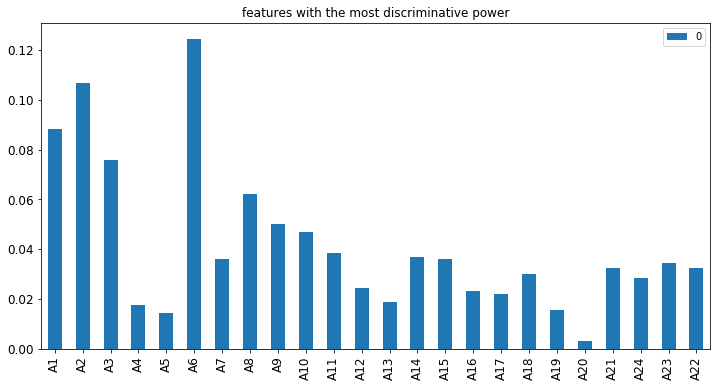

In [24]:
features_importance = pd.DataFrame(rf_model.feature_importances_, dataset.columns)
features_importance.plot(kind='bar', 
                         title ="features with the most discriminative power", 
                         figsize=(12, 6), 
                         fontsize=12)

A6, A2, A1, A3, and A8 are the top 5 most discriminative features